# Error Plots for JCPexample 1 

## Steady Stokes Flow in Rotating Disk

### Import Stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import DRLPDE_nn
import DRLPDE_param_solver
import DRLPDE_functions.DefineDomain
import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

### Load Model and Setup Variables

In [2]:
loadmodel = 'JCPexample1'

imagefilename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

### Load Trained model
nn_param = {'depth': 60,
                'width': 4,
                'x_dim':2,
                'is_unsteady':False,
                'output_dim':2
                }

loadmodel = 'JCPexample1'
Velocity_NN = DRLPDE_nn.IncompressibleNN
model = Velocity_NN(**nn_param)
model.load_state_dict(torch.load("savedmodels/" + loadmodel + ".pt"))

dim_space = 2
dim_full = dim_space

numpts_r = 10
numpts_th =  60

mu = 1
L = 1  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 1

### Analytic Solution
r,th = torch.meshgrid([torch.linspace(0,1, numpts_r), 
                       torch.linspace(0,2*math.pi, numpts_th)])

x1g = r*torch.cos(th)
x2g = r*torch.sin(th)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1)], dim=-1).requires_grad_(True)

integral_factor = 2*math.pi*r.detach().cpu().numpy()/(numpts_r-1)/(numpts_th-1)

u1_true = - v0*r*torch.sin(th)
u2_true = v0*r*torch.cos(th)

u_true = torch.stack([u1_true, u2_true], dim=-1)


ug = model(xg)
ug = ug.reshape([numpts_r, numpts_th, 2])

u1_approx = ug.select(-1, 0).detach().cpu().numpy()
u2_approx = ug.select(-1, 1).detach().cpu().numpy()

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()

u1_plot = u1_true.detach().cpu().numpy()
u2_plot = u2_true.detach().cpu().numpy()

L2_error = np.sqrt( np.sum( ((u1_approx - u1_plot)**2)*integral_factor) \
                   + np.sum( ((u2_approx - u2_plot)**2 )*integral_factor) )
Linf_error = np.max( [np.max( np.abs(u1_approx - u1_plot)) , np.max( np.abs(u2_approx - u2_plot))])

L2_norm_true = np.sqrt( np.sum( ( u1_plot**2)*integral_factor ) \
                       + np.sum( ( u2_plot**2)*integral_factor ) )

Linf_norm_true = np.max( [np.max( np.abs( u1_plot) ), np.max( np.abs( u2_plot))])

print("L2 Error = {:.4f}".format(L2_error))
print("Linf Error = {:.4f}".format(Linf_error))

print('Relative L2 Error = {:.4f}'.format(L2_error/L2_norm_true))
print('Relative Linf Error = {:.4f}'.format(Linf_error/Linf_norm_true))

L2 Error = 0.0210
Linf Error = 0.0213
Relative L2 Error = 0.0149
Relative Linf Error = 0.0213


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Plotting

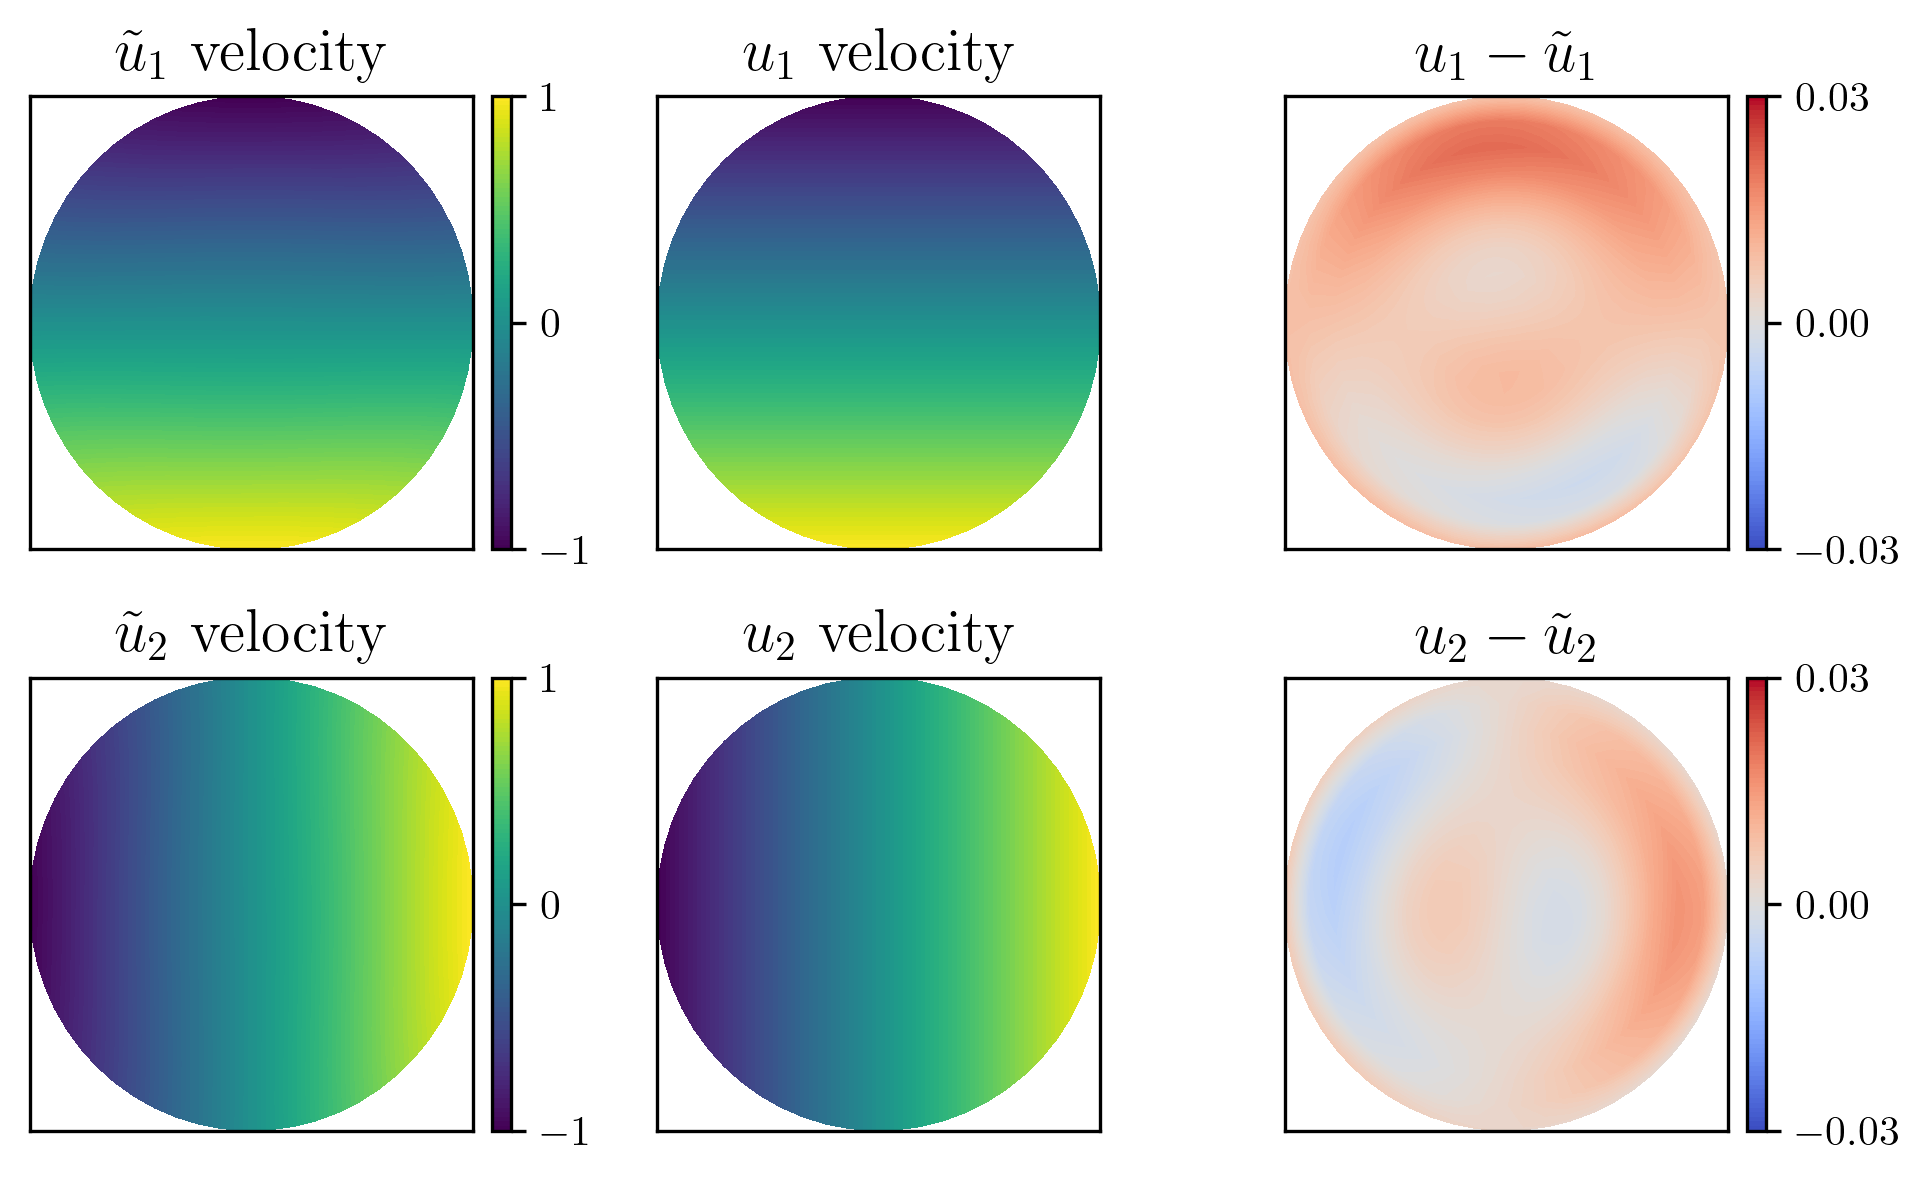

In [3]:

levels_stokes_flow = np.linspace(-1.0, 1.0, 100)
ticks_stokes_flow  = np.linspace(-1.0, 1.0, 3)

levels_error = np.linspace(-0.03, 0.03, 100)
ticks_error = np.linspace(-0.03, 0.03, 3)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[6.4, 4.0])
plt.tight_layout(pad=0.75)

contour0 = ax[0,0].contourf(x1plot, x2plot, u1_approx, levels = levels_stokes_flow,
                             cmap=plt.cm.viridis)

ax[0,0].set_title(r'$\tilde{u}_1$ velocity')

ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.01,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=ticks_stokes_flow, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)


contour1 = ax[0,1].contourf(x1plot, x2plot, u1_plot, levels = levels_stokes_flow,
                 cmap=plt.cm.viridis)

ax[0,1].set_title(r'$u_1$ velocity')
ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

contour2 = ax[0,2].contourf(x1plot, x2plot, u1_plot - u1_approx, 
                            levels = levels_error, cmap=plt.cm.coolwarm)

ax[0,2].set_title(r'$u_1 - \tilde{u}_1$')

ax[0,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar2_param = fig.add_axes(
    [ax[0,2].get_position().x1 + 0.01,
     ax[0,2].get_position().y0,
     0.01,
     ax[0,2].get_position().height])
colorbar2 = plt.colorbar(contour2, ticks=ticks_error, cax = colorbar2_param)
colorbar2.ax.tick_params(labelsize=10)



contour3 = ax[1,0].contourf(x1plot, x2plot, u2_approx, levels = levels_stokes_flow,
                 cmap=plt.cm.viridis)
ax[1,0].set_title(r'$\tilde{u}_2$ velocity')

ax[1,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar3_param = fig.add_axes(
    [ax[1,0].get_position().x1 + 0.01,
     ax[1,0].get_position().y0,
     0.01,
     ax[1,0].get_position().height])
colorbar3 = plt.colorbar(contour3, ticks=ticks_stokes_flow, cax = colorbar3_param)
colorbar3.ax.tick_params(labelsize=10)

contour4 = ax[1,1].contourf(x1plot, x2plot, u2_plot, levels = levels_stokes_flow,
                             cmap=plt.cm.viridis)

ax[1,1].set_title(r'$u_2$ velocity')
ax[1,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)


contour5 = ax[1,2].contourf(x1plot, x2plot, u2_approx - u2_plot, levels = levels_error,
                            cmap=plt.cm.coolwarm)

ax[1,2].set_title(r'$u_2 - \tilde{u}_2$')

ax[1,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar5_param = fig.add_axes(
    [ax[1,2].get_position().x1 + 0.01,
     ax[1,2].get_position().y0,
     0.01,
     ax[1,2].get_position().height])
colorbar5 = plt.colorbar(contour5, ticks=ticks_error, cax = colorbar5_param)
colorbar5.ax.tick_params(labelsize=10)
